**WHO IS TWEETING? TRUMP OR TRUDEAU**

This is a tweet classification project that attempts to properly classify tweets from two prominent North American politicians: Donald Trump and Justin Trudeau.The dataset is a corpus of tweets which were collected in November 2017. They are available in CSV format from https://www.kaggle.com/datasets/unofficialmerve/tweets-of-trump-and-trudeau 

The following steps describe the procedure used for building the classifier and evaluating results:

1. Dataset is loaded 

2. Apply preprocessing 

3. Include important features for training the model using Feature Extraction

4. Use visualization techniques to draw up insights using WordCloud

5. Use text vectorization

6. Split dataset as test and train data

7. Build several classification models and save them

8. Evaluate outcomes using of different models

9. Deploy the project

**Import necessary libraries and dependencies**

In [1]:
#main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib

#preprocessing libraries
import re
import nltk
from langdetect import detect, DetectorFactory
import spacy

#for visualization, import WordCloud
from wordcloud import WordCloud
#from Scikit-learn 
##import the splitting model
from sklearn.model_selection import train_test_split
##import the Vectorizer TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
##import the Classifying models to be built
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
##Import the evluation metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report


**Read and Inspect the dataset**

In [2]:
#Read the data
TRAIN_DATA_PATH = os.path.join(os.getcwd(), 'tweets.csv')
df = pd.read_csv(TRAIN_DATA_PATH)
df.head()


,id,author,status
0,1,Donald J. Trump,I will be making a major statement from the @W...
1,2,Donald J. Trump,Just arrived at #ASEAN50 in the Philippines fo...
2,3,Donald J. Trump,"After my tour of Asia, all Countries dealing w..."
3,4,Donald J. Trump,Great to see @RandPaul looking well and back o...
4,5,Donald J. Trump,Excited to be heading home to see the House pa...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      400 non-null    int64 
 1   author  400 non-null    object
 2   status  400 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.5+ KB


**Cleaning and Pre-processing of dataset**

In [4]:
##Check nulls
df.isna().sum(axis=0) ##no nulls

id        0
author    0
status    0
dtype: int64

In [5]:
##Check if data is balanced
df["author"].value_counts()  ##balanced

author
Donald J. Trump    200
Justin Trudeau     200
Name: count, dtype: int64

In [6]:
##Check unique values in the label column
df["author"].unique()

array(['Donald J. Trump', 'Justin Trudeau'], dtype=object)

In [7]:
##Change values in author (label column) to "trump" and "trudeau"
df["author"]= df["author"].str.replace ('Donald J. Trump', 'trump')
df["author"]= df["author"].str.replace ('Justin Trudeau', 'trudeau')
df["author"].unique()

array(['trump', 'trudeau'], dtype=object)

In [8]:
##Drop unnecessary columns
df.drop(columns=["id"], axis=1, inplace=True)
df.head()

,author,status
0,trump,I will be making a major statement from the @W...
1,trump,Just arrived at #ASEAN50 in the Philippines fo...
2,trump,"After my tour of Asia, all Countries dealing w..."
3,trump,Great to see @RandPaul looking well and back o...
4,trump,Excited to be heading home to see the House pa...


Tweets need to be preprocessed by removing any URLs, hashtags and mentions, punctuation marks, numbers and whitespaces along with converting them to lower case, tokenizing and lemmetizing further to normalize the text datasets. 

In [9]:
##Change all tweets in status to lower case
def lowerCase(data):
    return data.lower()
    
df["clean_tweet"] = df["status"].apply(lambda x: lowerCase(x))
df["clean_tweet"].head()

0    i will be making a major statement from the @w...
1    just arrived at #asean50 in the philippines fo...
2    after my tour of asia, all countries dealing w...
3    great to see @randpaul looking well and back o...
4    excited to be heading home to see the house pa...
Name: clean_tweet, dtype: object

In [10]:
#clean URLs, hashtags, mentions and numeric data
def cleaning (data):
    return re.sub('((www.[^s]+)|(https?://[^s]+)|(http?://[^s]+)|([^s]+.com)|(@[^\s]+)|(#)|(-?\d+(\.\d+)?))',' ',data)

df["clean_tweet"] = df["clean_tweet"].apply(lambda x: cleaning(x))
df["clean_tweet"]

0      i will be making a major statement from the   ...
1      just arrived at  asean  in the philippines for...
2      after my tour of asia, all countries dealing w...
3      great to see   looking well and back on the se...
4      excited to be heading home to see the house pa...
                             ...                        
395    rt   watch tmw:   discusses canada’s role in t...
396    today in ottawa, i met with the modern treaty ...
397    voici le sommaire de ma rencontre avec les pre...
398    rt    day  of   days of remembrance… show us y...
399    rt    jour  des   jours pour se souvenir… mont...
Name: clean_tweet, Length: 400, dtype: object

In [11]:
# Remove "rt" for "re-tweet" from the strings in the clean_tweet column
df["clean_tweet"] = df["clean_tweet"].str.replace("rt", "")
df["clean_tweet"]

0      i will be making a major statement from the   ...
1      just arrived at  asean  in the philippines for...
2      after my tour of asia, all countries dealing w...
3      great to see   looking well and back on the se...
4      excited to be heading home to see the house pa...
                             ...                        
395       watch tmw:   discusses canada’s role in the...
396    today in ottawa, i met with the modern treaty ...
397    voici le sommaire de ma rencontre avec les pre...
398        day  of   days of remembrance… show us you...
399        jour  des   jours pour se souvenir… montre...
Name: clean_tweet, Length: 400, dtype: object

In [12]:
#Clean whitespace and punctuation
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: " ".join(x.split()) if isinstance(x, str) else x)
df["clean_tweet"] = df['clean_tweet'].str.replace(r'[^\w\s]+', '', regex=True)
df["clean_tweet"]

0      i will be making a major statement from the up...
1      just arrived at asean in the philippines for m...
2      after my tour of asia all countries dealing wi...
3      great to see looking well and back on the sena...
4      excited to be heading home to see the house pa...
                             ...                        
395    watch tmw discusses canadas role in the world ...
396    today in ottawa i met with the modern treaty a...
397    voici le sommaire de ma rencontre avec les pre...
398    day of days of remembrance show us your poppie...
399    jour des jours pour se souvenir montrez votre ...
Name: clean_tweet, Length: 400, dtype: object

In [13]:
#Loop over data in tweets to detect language and add a new feature "languages"
languages = []

# Loop over the sentences in the list and detect their language
for sentence in df["clean_tweet"]:
    DetectorFactory.seed = 0
    languages.append(detect(sentence))
    
df["languages"] = languages
df["languages"].describe()

count     400
unique     12
top        en
freq      295
Name: languages, dtype: object

In [14]:
df['languages'][df["languages"]=="en"].value_counts()

languages
en    295
Name: count, dtype: int64

In [15]:
df['languages'][df["languages"]=="fr"].value_counts()

languages
fr    95
Name: count, dtype: int64

In [16]:
# Filter rows based on language, removing remaining 10 instances with languages different from en and fr
df= df[df["languages"].isin(['en', 'fr'])]
df

,author,status,clean_tweet,languages
0,trump,I will be making a major statement from the @W...,i will be making a major statement from the up...,en
1,trump,Just arrived at #ASEAN50 in the Philippines fo...,just arrived at asean in the philippines for m...,en
2,trump,"After my tour of Asia, all Countries dealing w...",after my tour of asia all countries dealing wi...,en
3,trump,Great to see @RandPaul looking well and back o...,great to see looking well and back on the sena...,en
4,trump,Excited to be heading home to see the House pa...,excited to be heading home to see the house pa...,en
...,...,...,...,...
395,trudeau,RT @googlecanada: Watch tmw: @JustinTrudeau di...,watch tmw discusses canadas role in the world ...,en
396,trudeau,"Today in Ottawa, I met with the Modern Treaty ...",today in ottawa i met with the modern treaty a...,en
397,trudeau,Voici le sommaire de ma rencontre avec les Pre...,voici le sommaire de ma rencontre avec les pre...,fr
398,trudeau,RT @VeteransENG_CA: #Day1 of 11 Days of Rememb...,day of days of remembrance show us your poppie...,en


In [17]:
df.head()

,author,status,clean_tweet,languages
0,trump,I will be making a major statement from the @W...,i will be making a major statement from the up...,en
1,trump,Just arrived at #ASEAN50 in the Philippines fo...,just arrived at asean in the philippines for m...,en
2,trump,"After my tour of Asia, all Countries dealing w...",after my tour of asia all countries dealing wi...,en
3,trump,Great to see @RandPaul looking well and back o...,great to see looking well and back on the sena...,en
4,trump,Excited to be heading home to see the House pa...,excited to be heading home to see the house pa...,en


In [18]:
df

,author,status,clean_tweet,languages
0,trump,I will be making a major statement from the @W...,i will be making a major statement from the up...,en
1,trump,Just arrived at #ASEAN50 in the Philippines fo...,just arrived at asean in the philippines for m...,en
2,trump,"After my tour of Asia, all Countries dealing w...",after my tour of asia all countries dealing wi...,en
3,trump,Great to see @RandPaul looking well and back o...,great to see looking well and back on the sena...,en
4,trump,Excited to be heading home to see the House pa...,excited to be heading home to see the house pa...,en
...,...,...,...,...
395,trudeau,RT @googlecanada: Watch tmw: @JustinTrudeau di...,watch tmw discusses canadas role in the world ...,en
396,trudeau,"Today in Ottawa, I met with the Modern Treaty ...",today in ottawa i met with the modern treaty a...,en
397,trudeau,Voici le sommaire de ma rencontre avec les Pre...,voici le sommaire de ma rencontre avec les pre...,fr
398,trudeau,RT @VeteransENG_CA: #Day1 of 11 Days of Rememb...,day of days of remembrance show us your poppie...,en


In [19]:
en_core = spacy.load('en_core_web_sm')
fr_core = spacy.load("fr_core_news_sm")
# Function to remove stopwords based on language
def remove_stopwords(data, language):
    if language == "en":
        doc = en_core(data)
        stopwords = en_core.Defaults.stop_words
    elif language == "fr":
        doc = fr_core(data)
        stopwords = fr_core.Defaults.stop_words
    else:
        return data
    
    tokens = [token.text for token in doc if token.text.lower() not in stopwords]
    return ' '.join(tokens)

df["clean_tweet"] = df.apply(lambda row: remove_stopwords(row["clean_tweet"], row["languages"]), axis=1)
df["clean_tweet"]

0         making major statement return dc time date set
1      arrived asean philippines final stop world lea...
2      tour asia countries dealing trade know rules c...
3        great looking senate floor help tax cuts reform
4      excited heading home house pass great tax bill...
                             ...                        
395    watch tmw discusses canadas role world ai gono...
396    today ottawa met modern treaty selfgoverning n...
397    sommaire rencontre premières nations autogouve...
398    day days remembrance poppies canadaremembers s...
399    jour jours souvenir montrez coquelicot lecanad...
Name: clean_tweet, Length: 390, dtype: object

In [20]:
df

,author,status,clean_tweet,languages
0,trump,I will be making a major statement from the @W...,making major statement return dc time date set,en
1,trump,Just arrived at #ASEAN50 in the Philippines fo...,arrived asean philippines final stop world lea...,en
2,trump,"After my tour of Asia, all Countries dealing w...",tour asia countries dealing trade know rules c...,en
3,trump,Great to see @RandPaul looking well and back o...,great looking senate floor help tax cuts reform,en
4,trump,Excited to be heading home to see the House pa...,excited heading home house pass great tax bill...,en
...,...,...,...,...
395,trudeau,RT @googlecanada: Watch tmw: @JustinTrudeau di...,watch tmw discusses canadas role world ai gono...,en
396,trudeau,"Today in Ottawa, I met with the Modern Treaty ...",today ottawa met modern treaty selfgoverning n...,en
397,trudeau,Voici le sommaire de ma rencontre avec les Pre...,sommaire rencontre premières nations autogouve...,fr
398,trudeau,RT @VeteransENG_CA: #Day1 of 11 Days of Rememb...,day days remembrance poppies canadaremembers s...,en


In [21]:
#lemmatizer
# Load the spaCy language models
en_core = spacy.load('en_core_web_sm', disable='parser')
fr_core = spacy.load("fr_core_news_sm", disable='parser')

# Function to lemmatize text based on language
def lemmatize_text(data, language):
    if language == "en":
        doc = en_core(data)
    elif language == "fr":
        doc = fr_core(data)
    else:
        return data
    
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

# Lemmatize the content in the specified column based on language
df['lemmatized'] = df.apply(lambda row: lemmatize_text(row['clean_tweet'], row["languages"]), axis=1)
df

,author,status,clean_tweet,languages,lemmatized
0,trump,I will be making a major statement from the @W...,making major statement return dc time date set,en,make major statement return dc time date set
1,trump,Just arrived at #ASEAN50 in the Philippines fo...,arrived asean philippines final stop world lea...,en,arrive asean philippines final stop world lead...
2,trump,"After my tour of Asia, all Countries dealing w...",tour asia countries dealing trade know rules c...,en,tour asia country deal trade know rule change ...
3,trump,Great to see @RandPaul looking well and back o...,great looking senate floor help tax cuts reform,en,great look senate floor help tax cut reform
4,trump,Excited to be heading home to see the House pa...,excited heading home house pass great tax bill...,en,excited head home house pass great tax bill mi...
...,...,...,...,...,...
395,trudeau,RT @googlecanada: Watch tmw: @JustinTrudeau di...,watch tmw discusses canadas role world ai gono...,en,watch tmw discuss canadas role world ai gonoh ...
396,trudeau,"Today in Ottawa, I met with the Modern Treaty ...",today ottawa met modern treaty selfgoverning n...,en,today ottawa meet modern treaty selfgoverne na...
397,trudeau,Voici le sommaire de ma rencontre avec les Pre...,sommaire rencontre premières nations autogouve...,fr,sommaire rencontre premier nation autogouverna...
398,trudeau,RT @VeteransENG_CA: #Day1 of 11 Days of Rememb...,day days remembrance poppies canadaremembers s...,en,day day remembrance poppie canadaremember s wi ev


In [22]:
##Tokenizing needs to be carried out as per language, since we have tweets in two English and French
def tokenizer(data, language):
    try:
        if language == "en":
            tokens = nltk.word_tokenize(data, language='english')
            return tokens
        elif language == "fr":
            tokens = nltk.word_tokenize(data, language='french')
            return tokens
        else:
            return []
    except Exception as e:
        raise Exception("An error occurred:", str(e))

#Applying the function tokenizer to dataset
df["tokenized_lemma"] = df.apply(lambda row: tokenizer(row["lemmatized"], row["languages"]), axis=1)
print(df["tokenized_lemma"].tail())

395    [watch, tmw, discuss, canadas, role, world, ai...
396    [today, ottawa, meet, modern, treaty, selfgove...
397    [sommaire, rencontre, premier, nation, autogou...
398    [day, day, remembrance, poppie, canadaremember...
399    [jour, jour, souvenir, montrer, coquelicot, le...
Name: tokenized_lemma, dtype: object


In [23]:
df

,author,status,clean_tweet,languages,lemmatized,tokenized_lemma
0,trump,I will be making a major statement from the @W...,making major statement return dc time date set,en,make major statement return dc time date set,"[make, major, statement, return, dc, time, dat..."
1,trump,Just arrived at #ASEAN50 in the Philippines fo...,arrived asean philippines final stop world lea...,en,arrive asean philippines final stop world lead...,"[arrive, asean, philippines, final, stop, worl..."
2,trump,"After my tour of Asia, all Countries dealing w...",tour asia countries dealing trade know rules c...,en,tour asia country deal trade know rule change ...,"[tour, asia, country, deal, trade, know, rule,..."
3,trump,Great to see @RandPaul looking well and back o...,great looking senate floor help tax cuts reform,en,great look senate floor help tax cut reform,"[great, look, senate, floor, help, tax, cut, r..."
4,trump,Excited to be heading home to see the House pa...,excited heading home house pass great tax bill...,en,excited head home house pass great tax bill mi...,"[excited, head, home, house, pass, great, tax,..."
...,...,...,...,...,...,...
395,trudeau,RT @googlecanada: Watch tmw: @JustinTrudeau di...,watch tmw discusses canadas role world ai gono...,en,watch tmw discuss canadas role world ai gonoh ...,"[watch, tmw, discuss, canadas, role, world, ai..."
396,trudeau,"Today in Ottawa, I met with the Modern Treaty ...",today ottawa met modern treaty selfgoverning n...,en,today ottawa meet modern treaty selfgoverne na...,"[today, ottawa, meet, modern, treaty, selfgove..."
397,trudeau,Voici le sommaire de ma rencontre avec les Pre...,sommaire rencontre premières nations autogouve...,fr,sommaire rencontre premier nation autogouverna...,"[sommaire, rencontre, premier, nation, autogou..."
398,trudeau,RT @VeteransENG_CA: #Day1 of 11 Days of Rememb...,day days remembrance poppies canadaremembers s...,en,day day remembrance poppie canadaremember s wi ev,"[day, day, remembrance, poppie, canadaremember..."


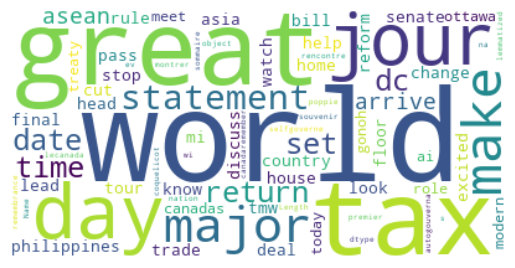

In [24]:
#WordCloud Visualization
# Create and generate a word cloud image
my_cloud = WordCloud(background_color = "white").generate(str(df['lemmatized']))

# Display the generated wordcloud image
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis("off")
#show the final image
plt.show()

In [25]:
df_trump = df[df["author"]=="trump"]
df_trump['lemmatized']

0           make major statement return dc time date set
1      arrive asean philippines final stop world lead...
2      tour asia country deal trade know rule change ...
3            great look senate floor help tax cut reform
4      excited head home house pass great tax bill mi...
                             ...                        
195    nice republican senator today multiple stand o...
196    president donald j trump proclaim october     ...
197           stock market hit record high job look good
198    entire world laugh take advantage people like ...
199    sen corker petent head foreign relations commi...
Name: lemmatized, Length: 192, dtype: object

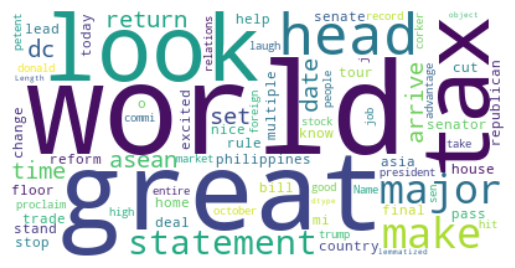

In [26]:
##WordCloud for Trump
df_trump = df[df["author"]=="trump"]

# Create and generate a word cloud image
my_cloud = WordCloud(background_color= 'white').generate(str(df_trump['lemmatized']))

# Display the generated wordcloud image
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis("off")
#show the final image
plt.show()

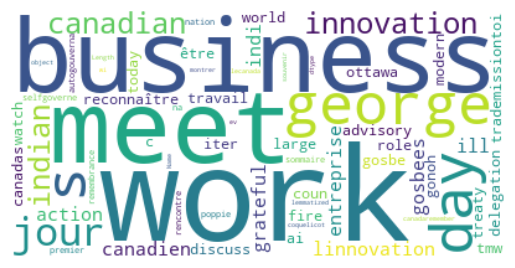

In [27]:
#WordCloud for Trudeau
df_trudeau = df[df["author"]=="trudeau"]

# Create and generate a word cloud image
my_cloud = WordCloud(background_color= 'white').generate(str([df_trudeau['lemmatized']]))

# Display the generated wordcloud image
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis("off")
#show the final image
plt.show()

In [28]:
df

,author,status,clean_tweet,languages,lemmatized,tokenized_lemma
0,trump,I will be making a major statement from the @W...,making major statement return dc time date set,en,make major statement return dc time date set,"[make, major, statement, return, dc, time, dat..."
1,trump,Just arrived at #ASEAN50 in the Philippines fo...,arrived asean philippines final stop world lea...,en,arrive asean philippines final stop world lead...,"[arrive, asean, philippines, final, stop, worl..."
2,trump,"After my tour of Asia, all Countries dealing w...",tour asia countries dealing trade know rules c...,en,tour asia country deal trade know rule change ...,"[tour, asia, country, deal, trade, know, rule,..."
3,trump,Great to see @RandPaul looking well and back o...,great looking senate floor help tax cuts reform,en,great look senate floor help tax cut reform,"[great, look, senate, floor, help, tax, cut, r..."
4,trump,Excited to be heading home to see the House pa...,excited heading home house pass great tax bill...,en,excited head home house pass great tax bill mi...,"[excited, head, home, house, pass, great, tax,..."
...,...,...,...,...,...,...
395,trudeau,RT @googlecanada: Watch tmw: @JustinTrudeau di...,watch tmw discusses canadas role world ai gono...,en,watch tmw discuss canadas role world ai gonoh ...,"[watch, tmw, discuss, canadas, role, world, ai..."
396,trudeau,"Today in Ottawa, I met with the Modern Treaty ...",today ottawa met modern treaty selfgoverning n...,en,today ottawa meet modern treaty selfgoverne na...,"[today, ottawa, meet, modern, treaty, selfgove..."
397,trudeau,Voici le sommaire de ma rencontre avec les Pre...,sommaire rencontre premières nations autogouve...,fr,sommaire rencontre premier nation autogouverna...,"[sommaire, rencontre, premier, nation, autogou..."
398,trudeau,RT @VeteransENG_CA: #Day1 of 11 Days of Rememb...,day days remembrance poppies canadaremembers s...,en,day day remembrance poppie canadaremember s wi ev,"[day, day, remembrance, poppie, canadaremember..."


In [29]:
#Drop the status column as the clean_tweet column replaces it
df.drop(columns=["status", "clean_tweet", 'tokenized_lemma', 'languages'], axis=1, inplace=True)
df.tail()

,author,lemmatized
395,trudeau,watch tmw discuss canadas role world ai gonoh ...
396,trudeau,today ottawa meet modern treaty selfgoverne na...
397,trudeau,sommaire rencontre premier nation autogouverna...
398,trudeau,day day remembrance poppie canadaremember s wi ev
399,trudeau,jour jour souvenir montrer coquelicot lecanada...


In [30]:
#Replace "trump" with 0 and "trudeau" with 1
df['author'] = df['author'].replace({'trump': 0, 'trudeau': 1})
df["author"]

0      0
1      0
2      0
3      0
4      0
      ..
395    1
396    1
397    1
398    1
399    1
Name: author, Length: 390, dtype: int64

In [31]:
df

,author,lemmatized
0,0,make major statement return dc time date set
1,0,arrive asean philippines final stop world lead...
2,0,tour asia country deal trade know rule change ...
3,0,great look senate floor help tax cut reform
4,0,excited head home house pass great tax bill mi...
...,...,...
395,1,watch tmw discuss canadas role world ai gonoh ...
396,1,today ottawa meet modern treaty selfgoverne na...
397,1,sommaire rencontre premier nation autogouverna...
398,1,day day remembrance poppie canadaremember s wi ev


In [32]:
# Splitting into features and target
X = df.drop(columns=['author'], axis=1)
y = df['author']

In [33]:
# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

In [34]:
#Initialize the TF-IDF Vectorizer
tvec= TfidfVectorizer(max_features= 4000, ngram_range= (1,2))
t_train=tvec.fit_transform(X_train["lemmatized"])
t_test=tvec.transform(X_test["lemmatized"])

In [35]:
t_train.shape, t_test.shape

((312, 4000), (78, 4000))

In [36]:
X_df= pd.DataFrame(t_test.toarray(), columns=tvec.get_feature_names_out())
X_df

,ab,abbypd,abbypd fall,abe,abe hideki,abe japanese,abe yield,aboriginal,aboriginal veteran,abuse,...,être,être ambitieux,être axé,être daccord,être plaisir,être réuni,être unir,đại,đại qua,ありがとうございます
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


*Build Classifying model using a multinomial NaiveBayes model*

In [37]:
# Create a MulitnomialNB model using Tfidfvectorizer
NB_classifier = MultinomialNB(force_alpha=True)

# Train model here
NB_classifier.fit(t_train, y_train)

# Run predict on the test data to get predictions
NB_classifier_pred = NB_classifier.predict(t_test)

# Calculate the accuracy of  predictions
NB_classifier_score = accuracy_score(y_test, NB_classifier_pred)
print('NaiveBayes Accuracy Score: ', NB_classifier_score)

#Evlaute with f1_score
NB_classifier_f1_score = f1_score(y_test, NB_classifier_pred, pos_label=1)
print ("NaiveBayes F1_score",NB_classifier_f1_score)

#Classification Report
report = classification_report(y_test, NB_classifier_pred, output_dict=True)
df_report_1 = pd.DataFrame(report).transpose()
df_report_1

NaiveBayes Accuracy Score:  0.9487179487179487
NaiveBayes F1_score 0.9487179487179488


,precision,recall,f1-score,support
0,0.902439,1.000000,0.948718,37.000000
1,1.000000,0.902439,0.948718,41.000000
accuracy,0.948718,0.948718,0.948718,0.948718
macro avg,0.951220,0.951220,0.948718,78.000000
weighted avg,0.953721,0.948718,0.948718,78.000000


*Build Classifying Model using LogisticRegression*

In [38]:
# Create a MulitnomialNB model using Tfidfvectorizer
LR_classifier = LogisticRegression()

# Train model
LR_classifier.fit(t_train, y_train)

# Run predict on test data to get predictions
LR_classifier_pred = LR_classifier.predict(t_test)

# Calculate the accuracy of predictions
LR_classifier_score = accuracy_score(y_test, LR_classifier_pred)
print('LogisticRegression Accuracy Score: ', LR_classifier_score)
#Evlaute with f1_score
LR_classifier_f1_score = f1_score(y_test, LR_classifier_pred, pos_label=1)
print ("LogisticRegression F1_score",LR_classifier_f1_score)
#Classification Report
report = classification_report(y_test, LR_classifier_pred, output_dict=True)
df_report_2 = pd.DataFrame(report).transpose()
df_report_2

LogisticRegression Accuracy Score:  0.9615384615384616
LogisticRegression F1_score 0.9620253164556963


,precision,recall,f1-score,support
0,0.925000,1.000000,0.961039,37.000000
1,1.000000,0.926829,0.962025,41.000000
accuracy,0.961538,0.961538,0.961538,0.961538
macro avg,0.962500,0.963415,0.961532,78.000000
weighted avg,0.964423,0.961538,0.961557,78.000000


Build Classifying Model using Random Forest 

In [39]:
# Create a Random Forest classifier object
RF_classifier = RandomForestClassifier(n_estimators= 100, random_state=45)

# Train the model using the training data
RF_classifier.fit(t_train, y_train)

# Make predictions on the test data
RF_classifier_pred = RF_classifier.predict(t_test)

# Evaluate the accuracy of the model
RF_classifier_score = accuracy_score(y_test, RF_classifier_pred)
print("RandomForest Score:", RF_classifier_score)
#Evlaute with f1_score
RF_classifier_f1_score = f1_score(y_test, RF_classifier_pred, pos_label=1)
print ("RandomForest F1_score",RF_classifier_f1_score)
#Classification Report
report = classification_report(y_test, RF_classifier_pred, output_dict=True)
df_report_3 = pd.DataFrame(report).transpose()
df_report_3

RandomForest Score: 0.9487179487179487
RandomForest F1_score 0.9487179487179488


,precision,recall,f1-score,support
0,0.902439,1.000000,0.948718,37.000000
1,1.000000,0.902439,0.948718,41.000000
accuracy,0.948718,0.948718,0.948718,0.948718
macro avg,0.951220,0.951220,0.948718,78.000000
weighted avg,0.953721,0.948718,0.948718,78.000000


##NaiveBayes Classifier & LogisticRegression Classifier return the best results

In [40]:
joblib.dump(NB_classifier, 'NaiveBayes_clf_model.pkl')
joblib.dump(LR_classifier, 'LogisticRegression_clf_model.pkl')


['LogisticRegression_clf_model.pkl']